# Logistic Regression and Multi-layer Perceptron Classifier for df_merged_neg_15x15_final

# Table of Contents<a class="anchor" id="Contents"></a>
* [Load Packages](#Packages)
* [Load Dataset](#Dataset)
    * [Train Test Validation Split](#Train_Test_Validation_Split)
* [Functions](#Functions)
* [Multi-layer Perceptron Classifier](#MLP)
    * [Run the Model](#Run_MLP)
    * [ROC Curve and Precision-Recall Curve](#Curve_MLP)
    * [Results](#Results_MLP)
* [Multi-layer Perceptron Classifier with PCA](#PCA)
* [Test data for different regions](#Regions)
* [Test data for different months](#Month)
* [Test data for different years](#Year)

# Load Packages<a class="anchor" id="Packages"></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import silhouette_score
from keras.optimizers import Adam
import random
import csv
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [3]:
from joblib import load

best_mlp = load('best_model/best_mlp_neg.joblib')
best_mlp_pc = load('best_model/best_mlp_neg_pc.joblib')

* [Table of Contents](#Contents)

# Load Dataset<a class="anchor" id="Dataset"></a>

In [4]:
df_merged_neg_15x15 = pd.read_csv('data/df_merged_neg_15x15_final.csv')
df_merged_neg_15x15

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel
0,2020-01-22,ukd4305-43260,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
1,2020-02-17,ukk3106-27200,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
2,2020-02-29,ukk4304-34200,0.0,0.0,0.278289,0.905697,0.381887,0.191762,0.0,0.0,...,0.912616,0.381887,0.209223,0.0,0.0,0.278289,0.908233,0.381887,0.198058,1
3,2020-03-01,ukk4305-25400,0.0,0.0,0.179310,0.897213,0.466615,0.156853,0.0,0.0,...,0.903999,0.464243,0.170801,0.0,0.0,0.179310,0.899777,0.466615,0.162112,1
4,2020-03-12,uke1200-08100,0.0,0.0,0.239333,0.908982,0.367827,0.207890,0.0,0.0,...,0.915927,0.367827,0.226820,0.0,0.0,0.239333,0.911528,0.367827,0.214716,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187106,2022-11-08,ukj3400-17700,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
187107,2022-12-02,ukk3103-29500,0.0,0.0,0.117570,0.892609,0.633440,0.143064,0.0,0.0,...,0.899428,0.633440,0.156091,0.0,0.0,0.117570,0.895108,0.633440,0.147761,1
187108,2022-12-07,ukk3103-29100,0.0,0.0,0.111443,0.906253,0.398421,0.198937,0.0,0.0,...,0.909478,0.388881,0.193924,0.0,0.0,0.108026,0.908791,0.401596,0.205469,1
187109,2022-12-08,ukk3103-29100,0.0,0.0,0.106985,0.894695,0.525795,0.148640,0.0,0.0,...,0.901454,0.524903,0.161904,0.0,0.0,0.105991,0.897206,0.527476,0.153521,0


In [5]:
counts_normalized = df_merged_neg_15x15['riskLevelLabel'].value_counts(normalize=True)
counts_normalized

0    0.971797
1    0.028203
Name: riskLevelLabel, dtype: float64

## Train Test Validation Split<a class="anchor" id="Train_Test_Validation_Split"></a>

In [6]:
train_labels_mean_zero = pd.read_csv('data/train_labels_mean_zero.csv')[['time', 'site']]
train_labels_mean_zero

,time,site
0,2021-05-25,ukk4305-25800
1,2022-07-04,ukk4305-25800
2,2022-08-08,ukk3105-31450
3,2022-08-27,ukk2206-20800
4,2020-06-08,uke1301-09020
...,...,...
112261,2021-07-19,ukj4210-12660
112262,2021-05-10,ukk4200-23200
112263,2020-08-10,ukk3104-33500
112264,2021-09-08,ukk1202-35700


In [7]:
validation_labels_mean_zero = pd.read_csv('data/validation_labels_mean_zero.csv')[['time', 'site']]
validation_labels_mean_zero

,time,site
0,2020-07-02,ukj3400-17400
1,2022-08-27,ukk3106-32200
2,2021-05-06,ukk4307-33900
3,2021-05-20,ukk4304-34100
4,2021-06-04,ukk3104-33200
...,...,...
37417,2021-07-28,ukk3103-29800
37418,2021-05-02,uke2206-07200
37419,2022-09-08,ukk4301-21800
37420,2021-07-18,ukj2403-15900


In [8]:
test_labels_mean_zero = pd.read_csv('data/test_labels_mean_zero.csv')[['time', 'site']]
test_labels_mean_zero

,time,site
0,2022-09-21,ukk3106-32100
1,2020-08-08,ukh1407-10750
2,2020-09-20,ukd4200-42100
3,2022-07-06,ukk2206-20900
4,2021-08-24,ukk4305-26100
...,...,...
37418,2021-09-22,ukj2402-15680
37419,2021-08-14,ukk3104-33500
37420,2022-05-20,ukk4305-25600
37421,2022-06-25,ukj3400-18000


In [9]:
# Train test validation split
df_train = df_merged_neg_15x15.merge(train_labels_mean_zero, on=['time', 'site'], how='inner')
df_val = df_merged_neg_15x15.merge(validation_labels_mean_zero, on=['time', 'site'], how='inner')
df_test = df_merged_neg_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_val.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_val = df_val.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_val = df_val
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Validation X Shape:', X_val.shape)
print('Validation y Shape:', y_val.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (112266, 192)
Training y Shape: (112266,)
Validation X Shape: (37422, 192)
Validation y Shape: (37422,)
Testing X Shape: (37423, 192)
Testing y Shape: (37423,)


* [Table of Contents](#Contents)

# Functions<a class="anchor" id="Functions"></a>

In [10]:
def pr_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    prc_auc = auc(recall, precision)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label='Precision recall curve (area = %0.2f)' % prc_auc)
    ax.axhline(y=counts_normalized[1], color='gray', linestyle='--', label='baseline')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [11]:
def plot_roc(model, X_test, y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [12]:
def cm(model,X_test,y_test):
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    cm.plot

In [13]:
def save_result(model,X_test,y_test):
    y_pred = model.predict(X_test)
    ACC = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    AUC_ROC = auc(fpr, tpr)
    PRE = precision_score(y_test, y_pred)
    REC = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    AUC_PRC = auc(recall, precision)
    F1 = f1_score(y_test, y_pred)
    return ACC, AUC_ROC, PRE, REC, AUC_PRC, F1

In [14]:
def get_metrics_from_test_df(df):
    y_pred = df['predictions']
    y_actual = df['riskLevelLabel']

    f1_ = round(f1_score(y_actual, y_pred), 3)
    precision = round(precision_score(y_actual, y_pred), 3)
    recall = round(recall_score(y_actual, y_pred), 3)
    pr_auc = round(average_precision_score(y_actual, y_pred), 3)
    roc_auc = round(roc_auc_score(y_actual, y_pred), 3)   
    accuracy = round(accuracy_score(y_actual, y_pred), 3)
    
    metrics_list = [len(df), f1_, precision, recall, pr_auc, roc_auc, accuracy]
    return metrics_list

* [Table of Contents](#Contents)

# Multi-layer Perceptron Classifier<a class="anchor" id="MLP"></a>

In [11]:
def mlp_model(X_train, y_train, X_val, y_val):
    # Apply Random Oversampling
    ros = RandomOverSampler()
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

#     params = {'hidden_layer_sizes': [(200,400,200,100), (300,600,300,150), (300, 600, 300), (400,800,400,200)],
#               'activation': ['logistic', 'relu'],
#               'alpha': [0.00001, 0.0001, 0.001]
#              }
    params = {'hidden_layer_sizes': [(200,400,200), (400,800,400,200)],
              'activation': ['logistic', 'relu'],
              'learning_rate': ['adaptive'],
              'alpha': [0.0001, 0.001, 0.01],
              'solver': ['adam', 'sgd']
             }


    best_f1 = 0
    best_params = {}
    for hidden_layer_sizes in params['hidden_layer_sizes']:
        for activation in params['activation']:
            for learning_rate in params['learning_rate']:
                for alpha in params['alpha']:
                    for solver in params['solver']:
                        mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                                 activation=activation,
                                                 learning_rate=learning_rate,
                                                 alpha=alpha,
                                                 solver=solver,
                                                 batch_size=1000,
                                                 random_state=100,
                                                 max_iter=500)
                        temp_model = mlp_model.fit(X_train_oversampled, y_train_oversampled)
                        y_val_pred = mlp_model.predict(X_val)
                        f1 = f1_score(y_val, y_val_pred)

                        if f1 > best_f1:
                            best_f1 = f1
                            best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation,
                                           'learning_rate': learning_rate, 'alpha': alpha, 'solver': solver}
                            best_mlp = temp_model

    print('Best Hyperparameters:', best_params)
    return best_mlp

## Run the Model<a class="anchor" id="Run_MLP"></a>

### Select the best hyperparameter on validation data

In [12]:
%%time
best_mlp = mlp_model(X_train, y_train, X_val, y_val)

Best Hyperparameters: {'hidden_layer_sizes': (400, 800, 400, 200), 'activation': 'relu', 'learning_rate': 'adaptive', 'alpha': 0.0001, 'solver': 'sgd'}
Wall time: 8h 31min 13s


In [13]:
from joblib import dump

# 保存模型到文件
dump(best_mlp, 'best_model/best_mlp_neg.joblib')

['best_model/best_mlp_neg.joblib']

## ROC Curve and Precision-Recall Curve<a class="anchor" id="Curve_MLP"></a>

### ROC Curve

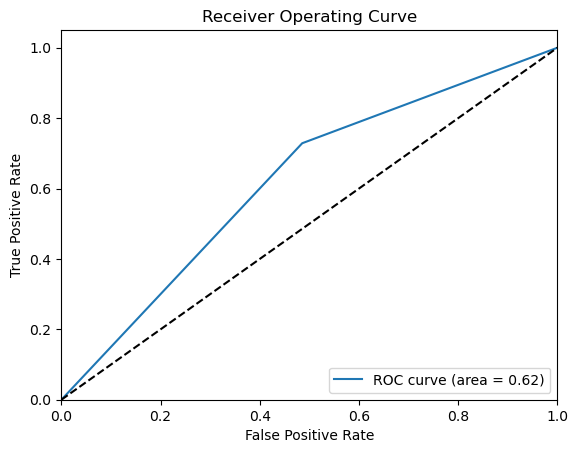

In [14]:
roc_mlp = plot_roc(best_mlp, X_test, y_test)

In [15]:
roc_mlp.savefig('results/ROC_neg_15x15_mlp.png')

### Precision-Recall Curve

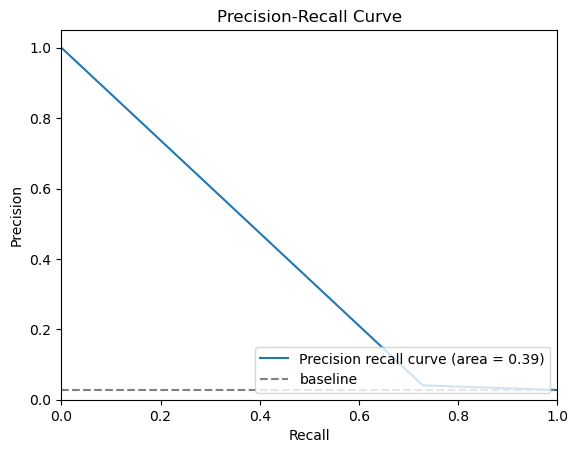

In [18]:
prc_mlp = pr_curve(best_mlp, X_test, y_test)

In [19]:
prc_mlp.savefig('results/PRC_neg_15x15_mlp.png')

## Results<a class="anchor" id="Results_MLP"></a>

MLPClassifier(batch_size=1000, hidden_layer_sizes=(400, 800, 400, 200),
              learning_rate='adaptive', max_iter=500, random_state=100,
              solver='sgd') 
On test data, Accuracy: 0.52
On test data, Precision: 0.04
On test data, Recall: 0.73
On test data, f1 score: 0.08 


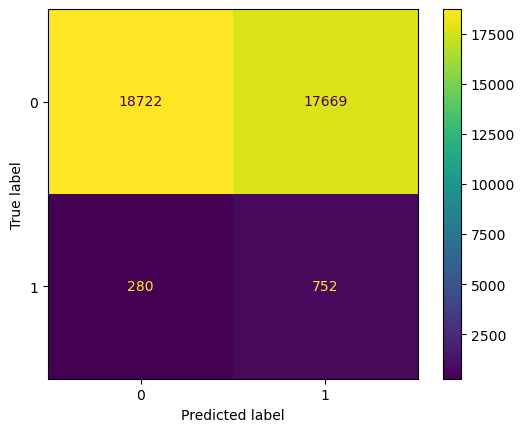

In [20]:
cm(best_mlp, X_test, y_test)

In [21]:
results_df_mlp = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_neg_15x15', *save_result(best_mlp,X_test,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_neg_15x15,0.520375,0.621575,0.040823,0.728682,0.388494,0.077315


In [22]:
results_df_mlp.to_csv('results/results_neg_15x15_mlp.csv')

* [Table of Contents](#Contents)

# Multi-layer Perceptron Classifier with PCA<a class="anchor" id="PCA"></a>

In [25]:
## Fit X_train, X_val, X_test with the PCA
pca = PCA(n_components = 5, random_state = 100)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_val_pc = pca.transform(X_val)
X_test_pc = pca.transform(X_test)
print('the shape of X_train after PCA:',X_train_pc.shape,'the shape of y train:',y_train.shape)
print('the shape of X_val after PCA:',X_val_pc.shape,'the shape of y train:',y_val.shape)
print('the shape of X_test after PCA:',X_test_pc.shape,'the shape of y test:',y_test.shape)

the shape of X_train after PCA: (112266, 5) the shape of y train: (112266,)
the shape of X_val after PCA: (37422, 5) the shape of y train: (37422,)
the shape of X_test after PCA: (37423, 5) the shape of y test: (37423,)


In [26]:
def best_mlp_model(X_train, y_train):
    ros = RandomOverSampler()
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)
    best_mlp = MLPClassifier(hidden_layer_sizes=(400, 800, 400, 200),
                                  activation='relu',
                                  learning_rate='adaptive',
                                  alpha=0.0001,
                                  solver='sgd',
                                  batch_size=1000,
                                  random_state=100,
                                  max_iter=200)
    best_mlp.fit(X_train_oversampled, y_train_oversampled)
    return best_mlp

In [27]:
best_mlp_pc = best_mlp_model(X_train_pc, y_train)

In [28]:
from joblib import dump
dump(best_mlp_pc, 'best_model/best_mlp_neg_pc_model.joblib')

['results/best_mlp_neg_pc_model.joblib']

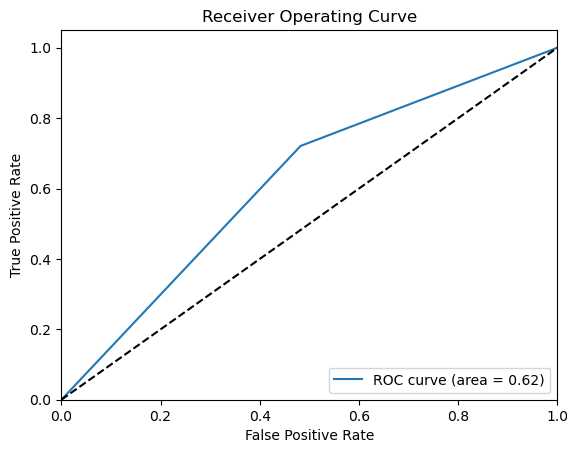

In [29]:
roc_mlp = plot_roc(best_mlp_pc, X_test_pc, y_test)

In [30]:
roc_mlp.savefig('results/ROC_neg_15x15_mlp_PCA.png')

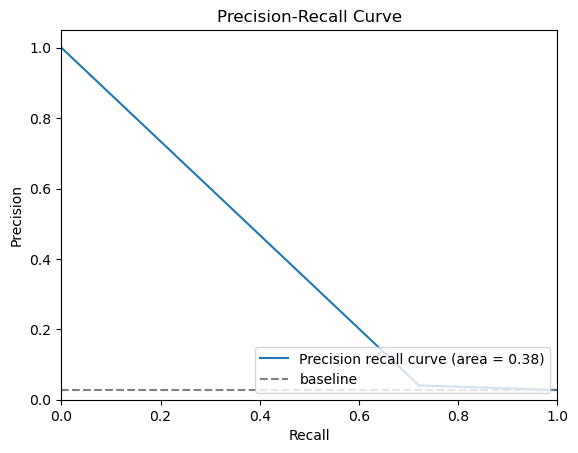

In [31]:
prc_mlp = pr_curve(best_mlp_pc, X_test_pc, y_test)

In [32]:
prc_mlp.savefig('results/PRC_neg_15x15_mlp_PCA.png')

MLPClassifier(batch_size=1000, hidden_layer_sizes=(400, 800, 400, 200),
              learning_rate='adaptive', random_state=100, solver='sgd') 
On test data, Accuracy: 0.52
On test data, Precision: 0.04
On test data, Recall: 0.72
On test data, f1 score: 0.08 


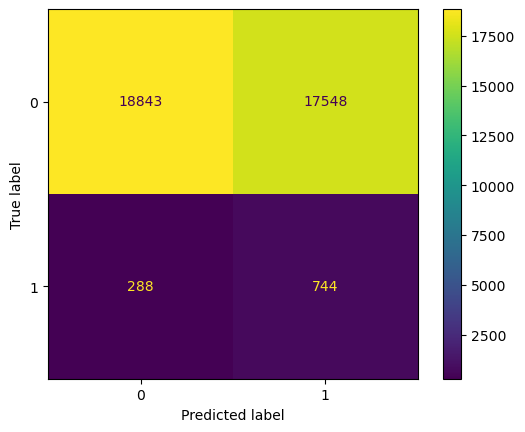

In [33]:
cm(best_mlp_pc, X_test_pc, y_test)

In [34]:
results_df_mlp = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_neg_15x15 with PCA', *save_result(best_mlp_pc,X_test_pc,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_neg_15x15 with PCA,0.523395,0.619362,0.040674,0.72093,0.38465,0.077003


In [35]:
results_df_mlp.to_csv('results/results_neg_15x15_mlp_PCA.csv')

* [Table of Contents](#Contents)

# Test data for different regions<a class="anchor" id="Regions"></a>

In [15]:
df_test_region = pd.read_csv('data/df_test_with_region.csv')

In [16]:
df_test_sw = df_test_region[df_test_region['region']=='South West']
df_test_sw = df_test_sw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_sw = df_test_sw.pop('riskLevelLabel')
X_test_sw = df_test_sw
df_test_se = df_test_region[df_test_region['region']=='South East']
df_test_se = df_test_se.drop(columns=['region', 'time', 'site'], axis=1)
y_test_se = df_test_se.pop('riskLevelLabel')
X_test_se = df_test_se
df_test_ee = df_test_region[df_test_region['region']=='East of England']
df_test_ee = df_test_ee.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ee = df_test_ee.pop('riskLevelLabel')
X_test_ee = df_test_ee
df_test_ne = df_test_region[df_test_region['region']=='North East']
df_test_ne = df_test_ne.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ne = df_test_ne.pop('riskLevelLabel')
X_test_ne = df_test_ne
df_test_nw = df_test_region[df_test_region['region']=='North West']
df_test_nw = df_test_nw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_nw = df_test_nw.pop('riskLevelLabel')
X_test_nw = df_test_nw
df_test_yh = df_test_region[df_test_region['region']=='Yorkshire and The Humber']
df_test_yh = df_test_yh.drop(columns=['region', 'time', 'site'], axis=1)
y_test_yh = df_test_yh.pop('riskLevelLabel')
X_test_yh = df_test_yh
df_test_em = df_test_region[df_test_region['region']=='East Midlands']
df_test_em = df_test_em.drop(columns=['region', 'time', 'site'], axis=1)
y_test_em = df_test_em.pop('riskLevelLabel')
X_test_em = df_test_em

In [17]:
df_test_ld = df_test_region[df_test_region['region']=='London']
df_test_ld = df_test_ld.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ld = df_test_ld.pop('riskLevelLabel')
X_test_ld = df_test_ld

In [19]:
results_df_mlp_regions = pd.DataFrame([['Multi-layer Perceptron Classifier', 'df_merged_neg_15x15', 'South West', *save_result(best_mlp,X_test_sw,y_test_sw)],
                                  ['','', 'South East', *save_result(best_mlp,X_test_se,y_test_se)], 
                                 ['','', 'East of England', *save_result(best_mlp,X_test_ee,y_test_ee)], 
                                 ['','', 'North East', *save_result(best_mlp,X_test_ne,y_test_ne)], 
                                 ['','', 'North West', *save_result(best_mlp,X_test_nw,y_test_nw)], 
                                 ['','', 'Yorkshire and The Humber', *save_result(best_mlp,X_test_yh,y_test_yh)],
                                 ['','', 'East Midlands', *save_result(best_mlp,X_test_em,y_test_em)], 
                                  ['','', 'London', *save_result(best_mlp,X_test_ld,y_test_ld)]],
                             columns=['Model', 'Sub-Model', 'Region', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_mlp_regions

,Model,Sub-Model,Region,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Multi-layer Perceptron Classifier,df_merged_neg_15x15,South West,0.576202,0.588020,0.034608,0.600451,0.322467,0.065445
1,,,South East,0.667368,0.629145,0.045242,0.588832,0.322364,0.084028
2,,,East of England,0.557265,0.502758,0.018746,0.446154,0.237578,0.035980
3,,,North East,0.500169,0.626328,0.045932,0.760870,0.407126,0.086634
4,,,North West,0.511537,0.533160,0.057753,0.557252,0.318844,0.104659
5,,,Yorkshire and The Humber,0.531659,0.523318,0.041860,0.514286,0.287353,0.077419
6,,,East Midlands,0.492816,0.423521,0.020173,0.350000,0.194426,0.038147
7,,,London,0.040462,0.500000,0.040462,1.000000,0.520231,0.077778


In [20]:
results_df_mlp_regions.to_csv('results/15_neg_MLP/Regions_neg_results.csv', index=False)

* [Table of Contents](#Contents)

# Test data for different months<a class="anchor" id="Month"></a>

In [13]:
df_test = df_merged_neg_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')
df_test['predictions'] = best_mlp.predict(X_test)

In [14]:
df_test['time'] = pd.to_datetime(df_test['time'])

In [16]:
df_test_may = get_metrics_from_test_df(df_test[df_test['time'].dt.month==5])
df_test_jun = get_metrics_from_test_df(df_test[df_test['time'].dt.month==6])
df_test_jul = get_metrics_from_test_df(df_test[df_test['time'].dt.month==7])
df_test_aug = get_metrics_from_test_df(df_test[df_test['time'].dt.month==8])
df_test_sep = get_metrics_from_test_df(df_test[df_test['time'].dt.month==9])

In [17]:
print(df_test_may)
print(df_test_jun)
print(df_test_jul)
print(df_test_aug)
print(df_test_sep)

[6430, 0.054, 0.028, 0.788, 0.025, 0.681, 0.577]
[7690, 0.057, 0.03, 0.717, 0.027, 0.611, 0.51]
[7829, 0.054, 0.028, 0.71, 0.026, 0.608, 0.51]
[7683, 0.092, 0.049, 0.706, 0.045, 0.612, 0.525]
[7429, 0.116, 0.063, 0.74, 0.058, 0.61, 0.492]


* [Table of Contents](#Contents)

# Test data for different years<a class="anchor" id="Year"></a>

In [22]:
df_test_2020 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2020])
df_test_2021 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2021])
df_test_2022 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2022])

In [23]:
print(df_test_2020)
print(df_test_2021)
print(df_test_2022)

[11766, 0.084, 0.044, 0.747, 0.041, 0.617, 0.496]
[12894, 0.083, 0.044, 0.714, 0.04, 0.607, 0.507]
[12763, 0.064, 0.034, 0.727, 0.03, 0.64, 0.557]


* [Table of Contents](#Contents)